In [1]:
DIR = "ptemcee"

# Import the necessary libraries
import pyazr
import emcee

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm import tqdm
from natsort import natsorted
from brick.azr import AZR as brick

# Define the data labels (in AZURE2 order)
labels = ["Meyer et al. (1976) - 84.3 deg",
          "Meyer et al. (1976) - 114.5 deg",
          "Meyer et al. (1976) - 144.1 deg", 
          "LUNA HPGe (2023)", 
          "LUNA BGO (2023)",
          "Felsenkeller (2023)",
          "ATOMKI (2023)",
          "Notre Dame (2023) - 0 deg",
          "Notre Dame (2023) - 55 deg",
          "Burtebaev et al. (2008)",
          "Lamb et al. (1957)",
          "Bailey et al. (1950)",
          "Vogl et al. (1963)",
          "Rolfs et al. (1974) - 0 deg",
          "Rolfs et al. (1974) - 90 deg"]

# Define the data colors
colors = { "Meyer et al. (1976) - 84.3 deg": "black",
           "Meyer et al. (1976) - 114.5 deg": "black",
           "Meyer et al. (1976) - 144.1 deg": "black",
           "LUNA HPGe (2023)": "black",
           "LUNA BGO (2023)": "black",
           "Felsenkeller (2023)": "cornflowerblue",
           "ATOMKI (2023)": "green",
           "Notre Dame (2023) - 0 deg": "darkcyan",
           "Notre Dame (2023) - 55 deg": "darkcyan",
           "Burtebaev et al. (2008)": "violet",
           "Lamb et al. (1957)": "grey",
           "Bailey et al. (1950)": "darkorchid",
           "Vogl et al. (1963)": "peru",
           "Rolfs et al. (1974) - 0 deg": "goldenrod",
           "Rolfs et al. (1974) - 90 deg": "goldenrod"
           }

# Group the data by extrapolated segment
segment_map = {0: [3, 4, 5, 6, 9, 10, 11, 12],
               1: [7, 13],
               2: [8],
               3: [14],
               4: [0],
               5: [1],
               6: [2]
               }

# Define the segment titles
titles = [r'(p,$\gamma$) Integrated', 
          r'(p,$\gamma$) Differential - 0 deg', r'(p,$\gamma$) Differential - 55 deg', r'(p,$\gamma$) Differential - 90 deg', 
          "(p,p) Differential - 84.3 deg", "(p,p) Differential - 114.5 deg", "(p,p) Differential - 144.1 deg"]

In [2]:
# Prepare pyazr to extrapolate the data
azr = pyazr.azure2( "12c_pg.azr" )
azr.extrap_mode( ) # Calculate the extrapolations and not the data segments
segments = azr.nsegments

# Get the lables
brk = brick( "12c_pg.azr" )
params_labels = brk.config.labels
params_labels[-len(labels):] = labels

In [3]:
bucket, bucket_lnp = [ ], [ ]
for t, file in enumerate( natsorted(glob("results/{}/*.h5".format(DIR))) ) :

    if( t > 15 ):
        continue

    # Read the .h5 file
    backend = emcee.backends.HDFBackend(file)

    # Get the number of samples after burn in
    nb  = 8000
    lnp = backend.get_log_prob(discard=nb)
    ii  = np.where(np.median(lnp, axis=0)!=-np.inf)[0]

    # Get only the first chain
    samples = backend.get_chain(discard=nb)[:, ii, :]
    samples = samples.reshape((-1, samples.shape[-1]))

    bucket.append( samples )
    bucket_lnp.append( lnp[:, ii] )

    print( "Found {} samples.".format( len( samples ) ) )

# Fuse all buckets in one array
data = np.vstack( bucket )
ndim = samples.shape[1]

# Shuffle the data to get a better representation
np.random.shuffle( data )
data = data[:10000]

Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.
Found 112000 samples.


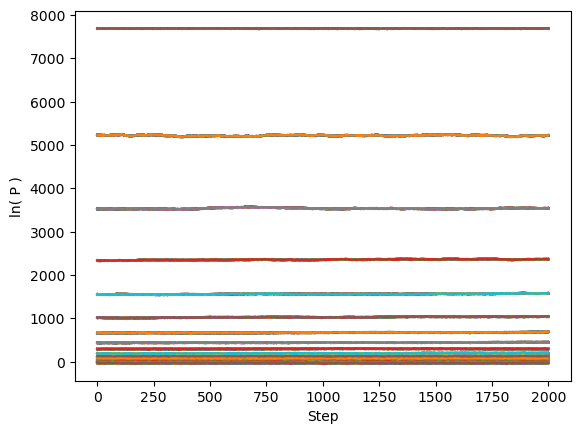

In [4]:
# Plot the posterior value
for i in range( len(bucket) ):
    plt.plot( bucket_lnp[i] )

plt.ylabel( "ln( P )" )
plt.xlabel( "Step" )

plt.savefig( "results/{}/figures/lnp.pdf".format(DIR) )
plt.show( )

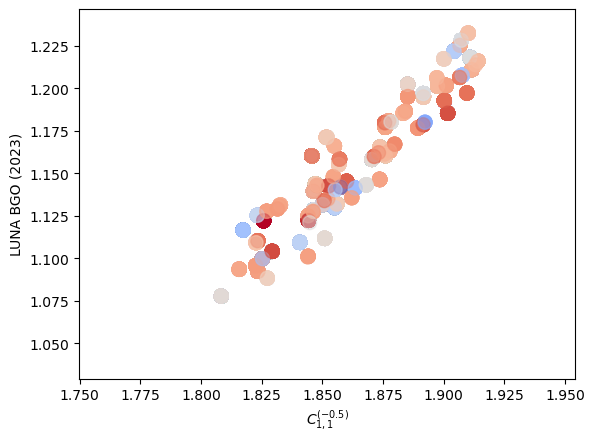

In [5]:
# Take the first walker
posterior = bucket_lnp[0]
chain = bucket[0][:len(posterior)]

i, j = 0, 18

min_1, max_1 = np.min( chain[:,0] ), np.max( chain[:,0] )
min_2, max_2 = np.min( chain[:,18] ), np.max( chain[:,18] )

# Plot the 2D scatter plot for 100 steps to create an animation
nsteps = 100
step = int(len( chain ) / nsteps)
param_1, param_2, c = [], [], []
for k in range( 0, len( chain ), step ):
    param_1.append( chain[k][i] )
    param_2.append( chain[k][j] )
    c.append( posterior[k][0] )
    plt.scatter( param_1, param_2, c=c, cmap="coolwarm", s=100, alpha=0.5 )
    plt.xlim( min_1, max_1 )
    plt.ylim( min_2, max_2 )
    plt.xlabel( params_labels[i] )
    plt.ylabel( params_labels[j] )
    plt.savefig( "animation/temp/fig_{}.png".format(int(k / step)) )


In [6]:
# Read all the plots
image_array = []
for my_file in natsorted( glob( "animation/temp/*.png" ) ):
    image = Image.open(my_file)
    image_array.append(image)

# Create the gif
image_array[0].save('animation/gif/param_1-param_2.gif'.format(DIR),
                    save_all=True, append_images=image_array[1:], optimize=False, duration=100, loop=0)

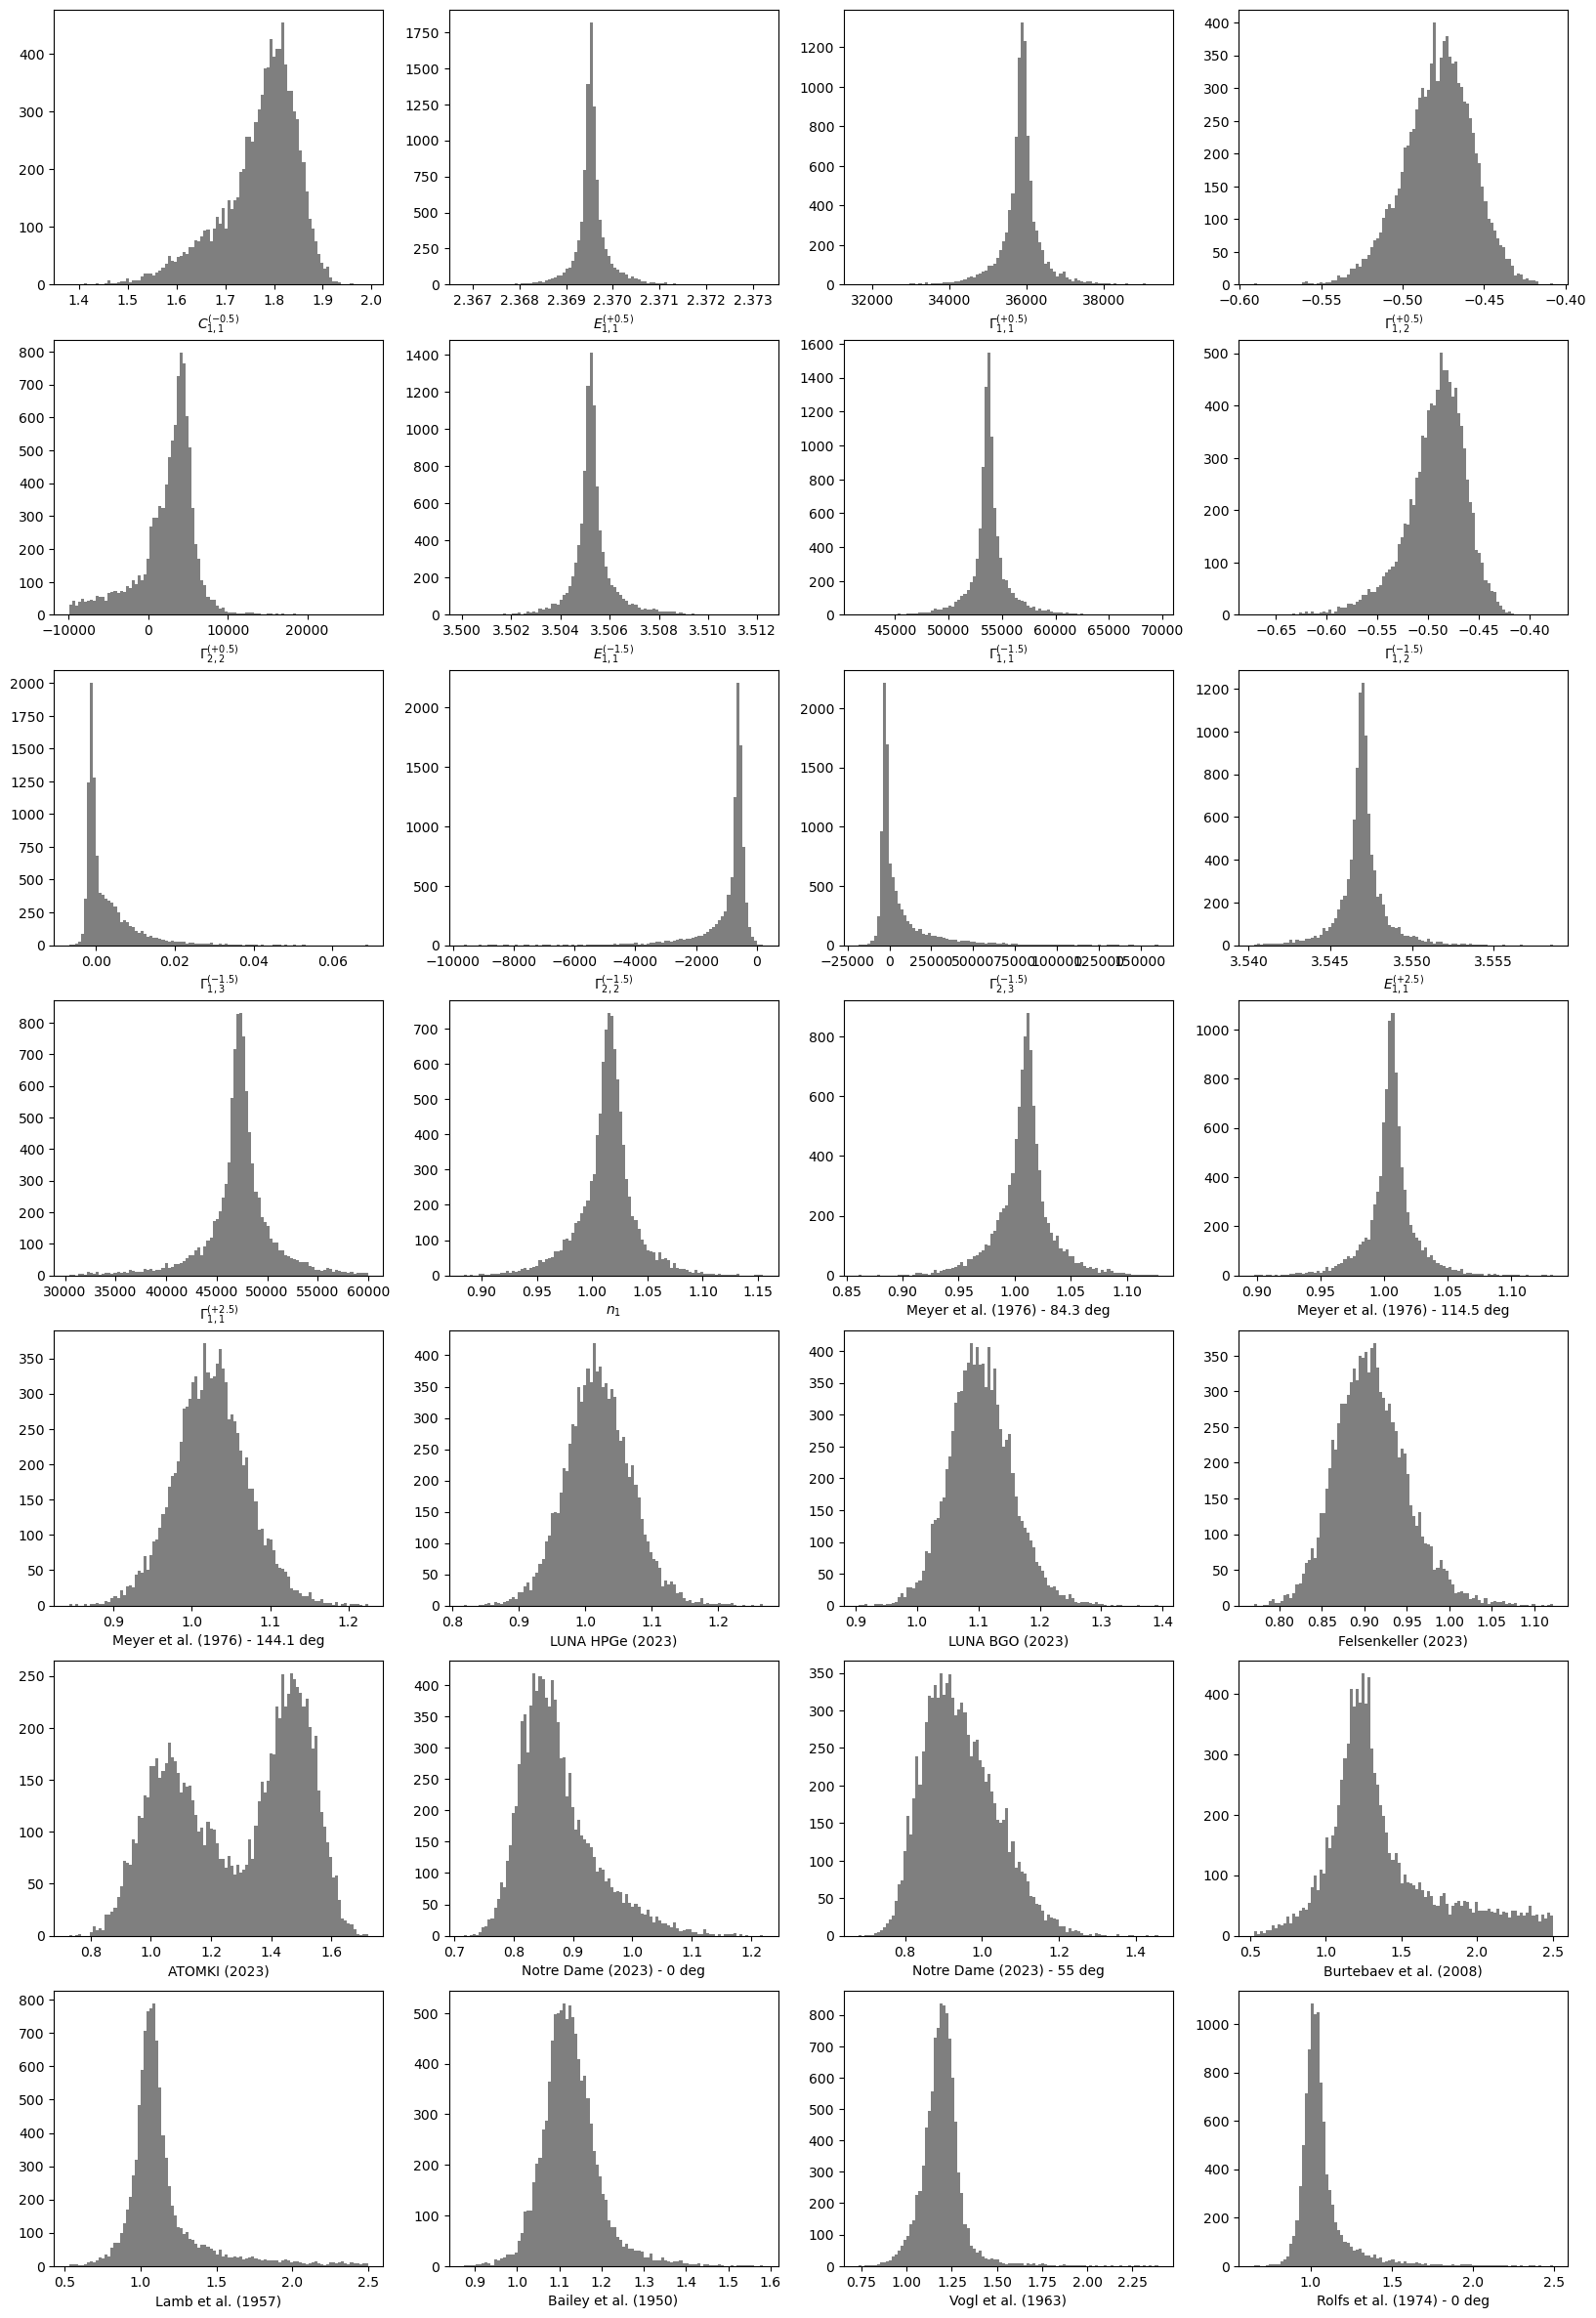

In [7]:
# Plot the parameters histograms
n, m = ndim, 4
fig, ax = plt.subplots( int(n/m), m, figsize=(20, 30) )
for i in range( n ):
    ax[i//m, i%m].hist( data[:, i], bins=100, color="black", lw=2, alpha=0.5 )
    ax[i//m, i%m].set_xlabel( params_labels[i] )

plt.savefig( "results/{}/figures/parameters.pdf".format(DIR) )

In [8]:
# Calculate the extrapolations
energies = azr.calculate_energies( data[0] )
results = { "Segment {}".format( i+1 ): [] for i in range( len( energies ) ) }
for par in tqdm( data[:1000] ):
    sample = azr.calculate_sfactor( par )
    for i in range( len( sample ) ):
        results[ "Segment {}".format( i+1 ) ].append( sample[ i ] )

100%|██████████| 1000/1000 [00:26<00:00, 37.56it/s]


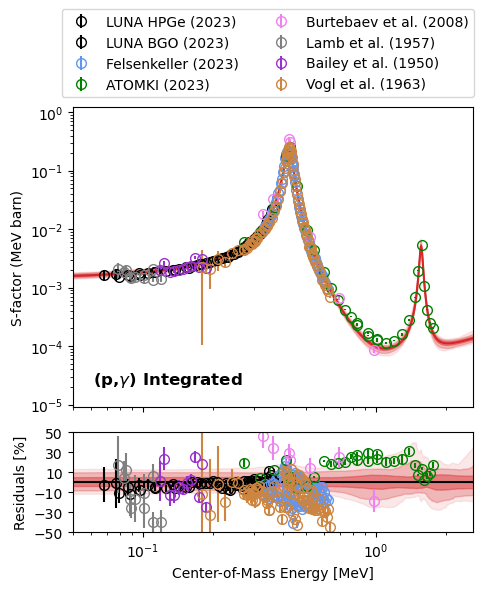

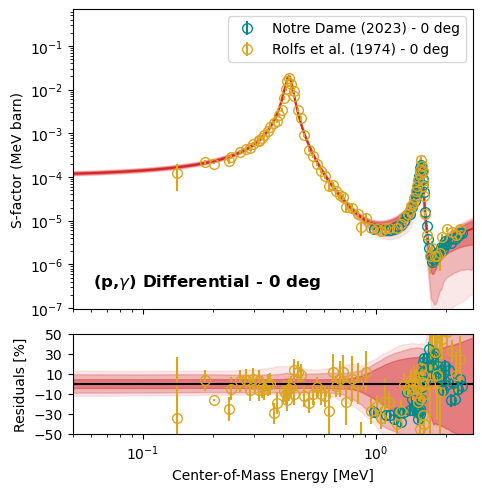

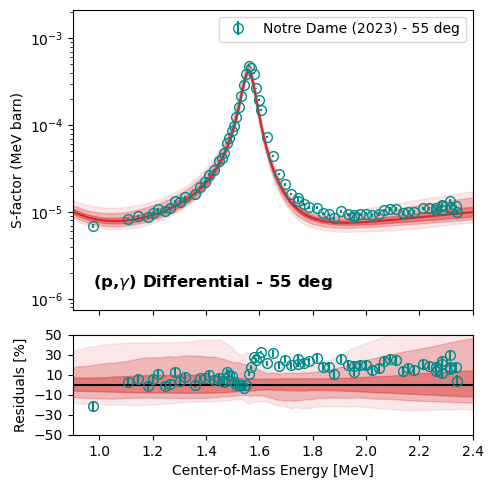

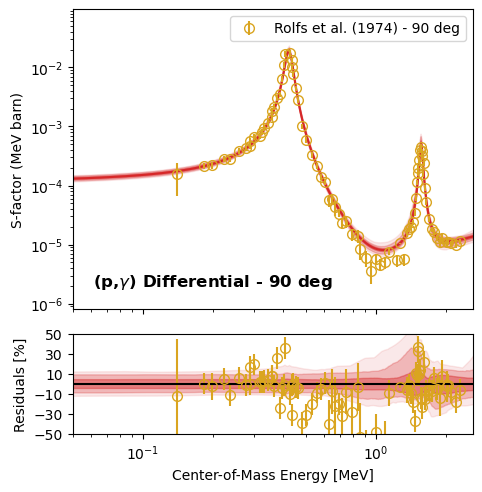

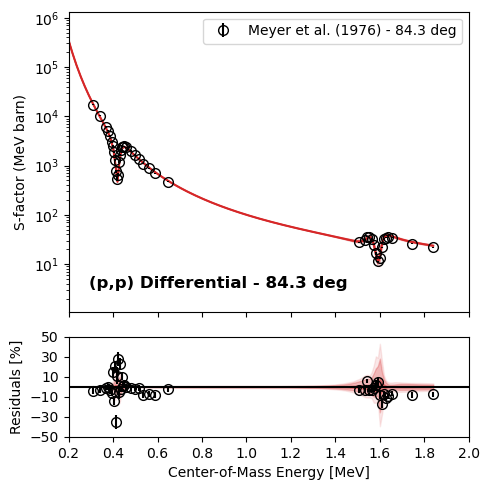

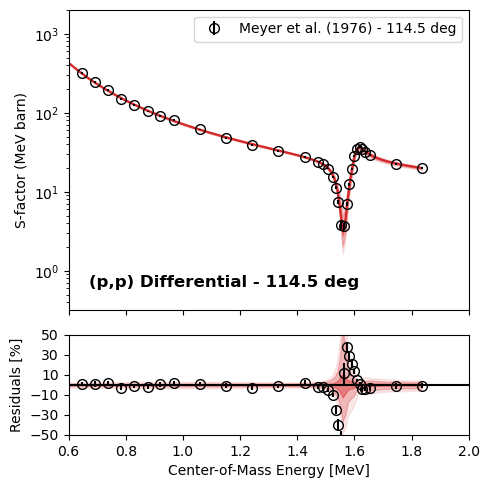

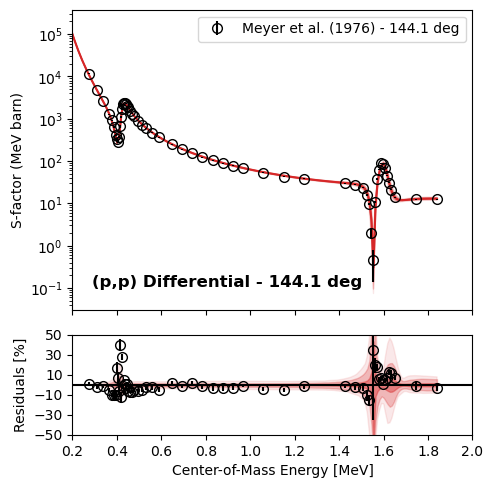

In [9]:
# Prepare the figures
for j, (segment, values) in enumerate(results.items()):
    mean = np.zeros( len( values[0] ) )
    sigma_1up, sigma_1low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    sigma_2up, sigma_2low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    sigma_3up, sigma_3low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    for i in range( len( values[0] ) ):
        mean[i] = np.mean( [ v[i] for v in values ] )
        sigma_1up[i] = np.percentile( [ v[i] for v in values ], 84 ) - mean[i]
        sigma_1low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 16 )
        sigma_2up[i] = np.percentile( [ v[i] for v in values ], 97.5 ) - mean[i]
        sigma_2low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 2.5 )
        sigma_3up[i] = np.percentile( [ v[i] for v in values ], 99.7 ) - mean[i]
        sigma_3low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 0.3 )

    min_x = 0.05 
    max_x = 2.6

    if( j == 2 ):
        min_x = 0.9
        max_x = 2.4

    if( j == 4 ):
        min_x = 0.2
        max_x = 2

    if( j == 5 ):
        min_x = 0.6
        max_x = 2

    if( j == 6 ):
        min_x = 0.2
        max_x = 2

    fig1 = plt.figure( figsize=(5,5) )
    ax1 = fig1.add_axes((.1,.35,.8,.6))
    ax1.set_ylabel( "S-factor (MeV barn)" )
    ax1.set_yscale( 'log' )
    if( j not in [4,5,6,2] ): ax1.set_xscale( 'log' )
    ax1.set_xticklabels([])

    ax1.set_title( titles[j], y=0.05, x=0.05, fontsize=12, fontweight='bold', horizontalalignment='left' )
    #ax1.text( 0.5, 0.95, titles[j], horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes, fontsize=12, fontweight='bold' )

    mask = (energies[j] > min_x) & (energies[j] <=  max_x)

    min_y = min( mean[mask] ) * 0.1
    max_y = max( mean[mask] ) * 5

    ax1.plot( energies[j], mean, color="tab:red" )

    for i in segment_map[j]:
        (line, _ , _) = ax1.errorbar( azr.energies[i], azr.sfactor[i], yerr=azr.sfactor_err[i], fmt="o", label=labels[i], color=colors[labels[i]], markersize=7 )
        line.set_markerfacecolor('none')

    ax1.fill_between( energies[j], mean-sigma_1low, mean+sigma_1up, alpha=0.40, color="tab:red" )
    ax1.fill_between( energies[j], mean-sigma_2low, mean+sigma_2up, alpha=0.25, color="tab:red" )
    ax1.fill_between( energies[j], mean-sigma_3low, mean+sigma_3up, alpha=0.10, color="tab:red" )

    ax1.set_xlim( min_x, max_x )
    ax1.set_ylim( min_y, max_y )

    if( j == 0 ):
        plt.legend( ncol=2, bbox_to_anchor=(1.02, 1.35) )
    elif( j == 1 ):
        ax1.set_ylim( min_y, max_y*7 )
        plt.legend( loc = 'upper right')
    else:
        plt.legend( )

    ax2 = fig1.add_axes((.1,.1,.8,.2))

    for i in segment_map[j]:
        # Find closest indexes of the mean respect to azr.energies[i]
        idx = [] 
        for k in range( len( azr.energies[i] ) ):
            idx.append( np.argmin( np.abs( energies[j] - azr.energies[i][k] ) ) )
        percent = 100 * ( azr.sfactor[i] - mean[idx] ) / azr.sfactor[i]
        percent_err = 100 * ( azr.sfactor_err[i] / azr.sfactor[i] )
        max_percent = max( abs( percent + percent_err ) )
        (line, _ , _) = ax2.errorbar( azr.energies[i], percent, yerr=percent_err, fmt="o", color=colors[labels[i]], markersize=7 )
        line.set_markerfacecolor('none')

    ax2.fill_between( energies[j], -100 * sigma_1low / mean, 100 * sigma_1up / mean, color="tab:red", alpha=0.40 )
    ax2.fill_between( energies[j], -100 * sigma_2low / mean, 100 * sigma_2up / mean, color="tab:red", alpha=0.25, label='2 sigma' )
    ax2.fill_between( energies[j], -100 * sigma_3low / mean, 100 * sigma_3up / mean, color="tab:red", alpha=0.10, label='3 sigma' )
    ax2.axhline( 0, color="black" )
    
    ax2.set_xlabel( "Center-of-Mass Energy [MeV]" )
    ax2.set_ylabel( "Residuals [%]" )

    ax2.set_yticks( [-50, -30, -10, 10, 30, 50] )
    
    if( j not in [4,5,6,2] ): ax2.set_xscale( 'log' )

    ax2.set_xlim( min_x, max_x )
    ax2.set_ylim( -50, 50 )
    
    plt.savefig( "results/{}/figures/{}.pdf".format( DIR, segment ), bbox_inches='tight' )
    plt.show( )

    np.savetxt( "results/{}/data/{}.txt".format( DIR, segment ), np.array( [ energies[j], mean, sigma_1up, sigma_1low, sigma_2up, sigma_2low, sigma_3up, sigma_3low ] ).T )

ValueError: The number of FixedLocator locations (28), usually from a call to set_ticks, does not match the number of labels (29).

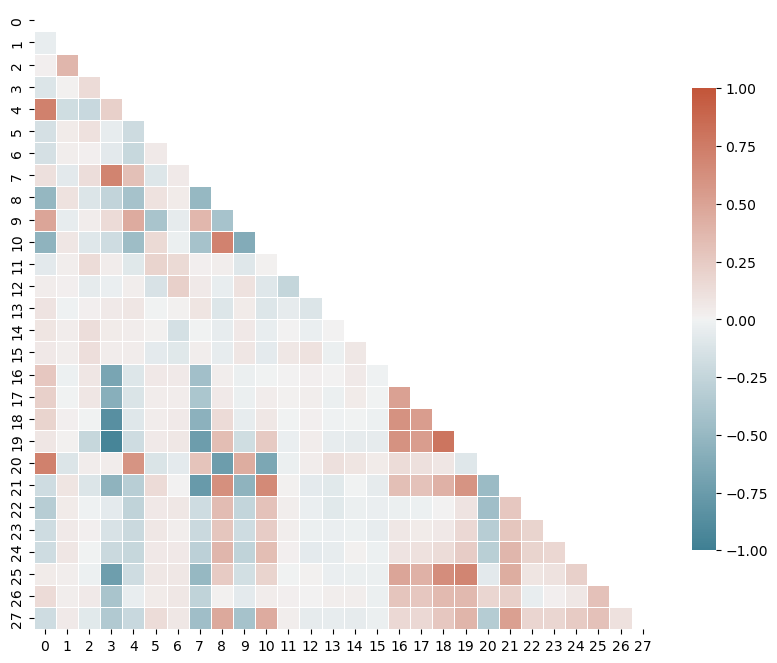

In [10]:
# Calculate correlation matrix for data
correlation = np.corrcoef( data.T )

# Get only the lower triangular part
corr = np.tril( correlation, k=-1 )
mask = np.triu( correlation )

# Plot the correlations
fig = plt.figure( figsize=(10,12) )

cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.collections[0].set_clim(-1,1)

ax.set_xticklabels(params_labels, rotation=90)
ax.set_yticklabels(params_labels, rotation=0)

plt.savefig( "results/{}/figures/correlation.pdf".format(DIR), bbox_inches='tight' )
plt.show( )